# **Evaluation of models**

**Approach:**
1. I find another dataset(no label) on kaggle, use it as the evaluation dataset.
2. I use LLM to label the dataset, then check the accuracy manually.
3. I test the tfidflr and bert through endpoint, metrics: accuracy, f1 score, latency.


**Dataset:**  
https://www.kaggle.com/datasets/nirajanrana/tmdb-movie-reviews

---
## **Summary**

### **Performance & Robustness**

**BERT >> TF-IDF**
The evaluation dataset is significantly different from the IMDB training dataset — it’s newer, longer, and more complex (with a higher number of unique vocabulary terms).

* **TF-IDF** baseline model drops **11% accuracy** and **7% F1 score**.
* **BERT** drops only **5.2% accuracy** and **3.8% F1 score**.

This is reasonable since BERT's max input length is 512 tokens, while the average word count in the dataset exceeds 1000.
Transformers like BERT show superior robustness by capturing more complex context and handling unseen vocabulary better, thanks to their pretraining. In contrast, TF-IDF was trained only on the IMDB dataset, and its performance drops drastically due to its limited vocabulary coverage.

---

### **Latency**

* **TF-IDF**: \~**10ms** inference time — extremely fast due to its simplicity and non-sequential processing.
* **BERT**: \~**150ms** inference time — slower due to model complexity and longer sequence lengths. Performance is sensitive to both input size and hardware.

---

### **Model & Dependency Size**

* **DistilBERT**: \~**268MB** (model + tokenizer)

* **TF-IDF + LR**: \~**1MB** (vectorizer + logistic regression model)

* **scikit-learn**: \~**120MB** on disk

* **PyTorch (CPU)**: \~**1GB** on disk

---

### **Trade-off**

Choosing **DistilBERT** provides **stronger robustness** and **context understanding**, making it reliable for more complex, vocabulary-rich, and unseen data. The cost is **higher latency (\~150ms)** and **larger model/dependency size** (\~268MB model, 1GB PyTorch).

In contrast, **TF-IDF + LR** is extremely **fast (\~10ms)** and **lightweight (\~1MB)** with minimal resource needs. However, it lacks generalization ability and **struggles with unseen or complex input**, causing notable performance degradation outside its training distribution.



In [23]:
# ======================================================
# Below is the code for the evaluation of the model.
# ======================================================

In [1]:
import pandas as pd
import requests

In [2]:
# Load the dataset
df = pd.read_csv("movie_reviews_dataset.csv")
df.head()

,movie_id,reviews
0,19995,"['Avatar is an overwhelming, immersive spectac..."
1,285,['Part 3 Jack is stuck in Davy Jones locker. W...
2,206647,"['<a href=""http://www.cutprintfilm.com/reviews..."
3,49026,"[""I felt like this was a tremendous end to Nol..."
4,49529,['Totally forgettable and full of stereotypes'...


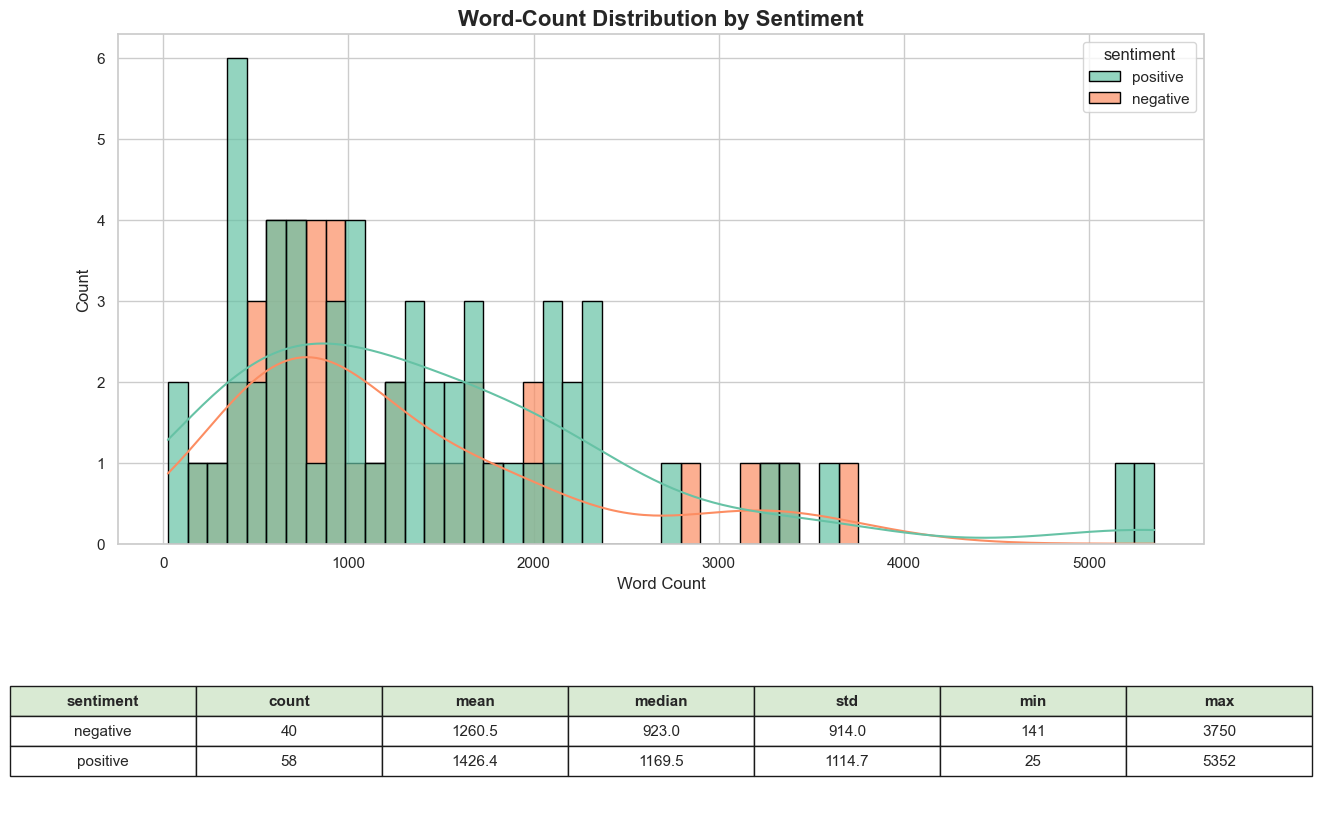

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme for consistent plotting aesthetics
sns.set_theme(style="whitegrid")

# Compute the word count of each review
df['word_count'] = df['reviews'].apply(lambda x: len(str(x).split()))

# Create a summary table grouped by sentiment (if sentiment exists)
if 'sentiment' in df.columns:
    summary_table = (
        df.groupby('sentiment')['word_count']
          .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
          .round(1)
          .reset_index()
    )
else:
    summary_table = (
        df['word_count']
          .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
          .to_frame().T
          .round(1)
    )

# Create a figure with two vertical sections (plot on top, table below)
fig = plt.figure(figsize=(14, 10))
grid = plt.GridSpec(2, 1, height_ratios=[3.5, 1], hspace=0.35)

# First subplot: Histogram of word counts (by sentiment if available)
ax1 = fig.add_subplot(grid[0])
if 'sentiment' in df.columns:
    sns.histplot(
        data=df,
        x='word_count',
        hue='sentiment',
        bins=50,
        kde=True,
        palette='Set2',
        alpha=0.7,
        edgecolor='black',
        ax=ax1
    )
    ax1.set_title('Word-Count Distribution by Sentiment', fontsize=16, fontweight='bold')
else:
    sns.histplot(
        data=df,
        x='word_count',
        bins=50,
        kde=True,
        color='skyblue',
        alpha=0.7,
        edgecolor='black',
        ax=ax1
    )
    ax1.set_title('Word-Count Distribution', fontsize=16, fontweight='bold')
ax1.set_xlabel('Word Count', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Second subplot: Summary statistics table
ax2 = fig.add_subplot(grid[1])
ax2.axis('off')

table = ax2.table(
    cellText=summary_table.values,
    colLabels=summary_table.columns,
    cellLoc='center',
    loc='center'
)

# Adjust table appearance
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#d9ead3')
    else:
        cell.set_facecolor('#ffffff')

plt.show()

**The reviews in this dataset is wild, kind of imbalanced. It can give a meaningful evaluation results of our models.**

In [4]:
# Use LLM to make the label of the dataset.
import ast
import json
import time

def get_llm_sentiment(text):
    """
    Get sentiment prediction from LLM endpoint.
    
    Args:
        text (str): Text to analyze.
        
    Returns:
        dict: Response from LLM endpoint with sentiment and probabilities.
    """
    # Try different host addresses
    hosts = ["http://localhost:8000", "http://127.0.0.1:8000", "http://0.0.0.0:8000"]
    
    payload = {
        "text": text,
        "version": "1.0.0"
    }
    headers = {
        "Content-Type": "application/json"
    }
    
    for host in hosts:
        url = f"{host}/api/v1/predict/llm"
        try:
            response = requests.post(url, json=payload, headers=headers, timeout=10)
            response.raise_for_status()
            print(f"✓ Successfully connected to {host}")
            return response.json()
        except Exception as e:
            print(f"✗ Failed to connect to {host}: {e}")
            continue
    
    return None

def test_api_connection():
    """Test if any of the API endpoints are accessible."""
    print("Testing API connection...")
    result = get_llm_sentiment("test")
    if result:
        print("✓ API connection successful!")
        return True
    else:
        print("✗ Cannot connect to API. Please ensure the server is running.")
        return False

# Test API connection first
if not test_api_connection():
    print("Please start the API server first. You can try:")
    print("1. Check if the server is running on port 8000")
    print("2. Try running the server with: python main.py (or similar)")
    print("3. Make sure the server is accessible from this machine")
else:
    print("Proceeding with sentiment analysis...")

# Extract first review from each list and call LLM endpoint
sentiments = []
pos_probs = []
neg_probs = []

for idx, row in df.iterrows():
    # Parse the string representation of list to get actual list
    reviews_list = ast.literal_eval(row['reviews'])
    first_review = reviews_list[0] if reviews_list else ""
    
    # Get sentiment from LLM
    result = get_llm_sentiment(first_review)
    
    if result:
        sentiments.append(result['sentiment'])
        pos_probs.append(result['positive_probability'])
        neg_probs.append(result['negative_probability'])
    else:
        sentiments.append("Failed")
        pos_probs.append(None)
        neg_probs.append(None)
    
    # Add small delay to avoid overwhelming the API
    time.sleep(0.1)
    
    print(f"Processed {idx + 1}/{len(df)} reviews")

# Add new columns to dataframe
df['sentiment'] = sentiments
df['positive_probability'] = pos_probs
df['negative_probability'] = neg_probs

print("Labeling completed!")
df.head()


Testing API connection...
✓ Successfully connected to http://localhost:8000
✓ API connection successful!
Proceeding with sentiment analysis...
✓ Successfully connected to http://localhost:8000
Processed 1/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 2/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 3/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 4/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 5/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 6/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 7/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 8/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 9/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 10/99 reviews
✓ Successfully connected to http://localhost:8000
Processed 11/99 reviews
✓ Successfully connected to http://localhost:8000
Pr

,movie_id,reviews,sentiment,positive_probability,negative_probability
0,19995,"['Avatar is an overwhelming, immersive spectac...",positive,1.0,0.0
1,285,['Part 3 Jack is stuck in Davy Jones locker. W...,positive,1.0,0.0
2,206647,"['<a href=""http://www.cutprintfilm.com/reviews...",negative,0.0,1.0
3,49026,"[""I felt like this was a tremendous end to Nol...",positive,1.0,0.0
4,49529,['Totally forgettable and full of stereotypes'...,negative,0.0,1.0


**Manually Checked first 10 rows, seems no problem.**

In [5]:
# Save the dataset to csv.
df.to_csv("movie_reviews_dataset_labeled.csv", index=False)

In [17]:
# Model Evaluation: BERT vs Baseline (TF-IDF)
import pandas as pd
import requests
import numpy as np
import ast
import time
from sklearn.metrics import accuracy_score, f1_score, log_loss

def get_prediction(text, model_type):
    """Get prediction from API endpoint"""
    url = f"http://127.0.0.1:8000/api/v1/predict/{model_type}"
    payload = {"text": text, "version": "1.0.0"}
    headers = {"Content-Type": "application/json"}
    
    try:
        response = requests.post(url, json=payload, timeout=30)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error with {model_type}: {e}")
        return None

def calculate_metrics(y_true, y_pred, y_proba):
    """Calculate evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1

# Load labeled dataset
print("Loading dataset...")
df = pd.read_csv("movie_reviews_dataset_labeled.csv")
df = df[df['sentiment'] != 'Failed'].reset_index(drop=True)

# Prepare ground truth
y_true = [1 if sentiment == 'positive' else 0 for sentiment in df['sentiment']]
print(f"Dataset: {len(df)} reviews")

# Test both models
results = {}
models = ['baseline', 'bert']

for model in models:
    print(f"\nTesting {model}...")
    predictions = []
    probabilities = []
    latencies = []
    
    for idx, row in df.iterrows():
        # Get review text
        reviews_list = ast.literal_eval(row['reviews'])
        review_text = reviews_list[0] if reviews_list else ""
        
        # Measure latency and get prediction
        start_time = time.perf_counter()
        result = get_prediction(review_text, model)
        end_time = time.perf_counter()
        
        if result:
            pred_label = 1 if result['sentiment'] == 'positive' else 0
            predictions.append(pred_label)
            probabilities.append(result['positive_probability'])
            latencies.append((end_time - start_time) * 1000)  # Convert to ms
        else:
            raise Exception(f"Error with {model}: {result}")
        
        if (idx + 1) % 20 == 0:
            print(f"  Processed {idx + 1}/{len(df)}")
    
    # Calculate metrics
    valid_latencies = [lat for lat in latencies if lat > 0]
    accuracy, f1 = calculate_metrics(y_true, predictions, probabilities)
    
    results[model] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'avg_latency_ms': np.mean(valid_latencies),
        'median_latency_ms': np.median(valid_latencies)
    }
    
    print(f"  {model} completed!")

print("\nEvaluation completed!")


Loading dataset...
Dataset: 98 reviews

Testing baseline...
  Processed 20/98
  Processed 40/98
  Processed 60/98
  Processed 80/98
  baseline completed!

Testing bert...
  Processed 20/98
  Processed 40/98
  Processed 60/98
  Processed 80/98
  bert completed!

Evaluation completed!


In [19]:
# Display Results Table
import pandas as pd

# Create comparison table
comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name.upper(),
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'F1 Score': f"{metrics['f1_score']:.4f}",
        'Avg Latency (ms)': f"{metrics['avg_latency_ms']:.2f}",
        'Median Latency (ms)': f"{metrics['median_latency_ms']:.2f}"
    })

results_table = pd.DataFrame(comparison_data)
print("Model Performance Comparison:")
print("="*60)
print(results_table.to_string(index=False))

# Calculate performance differences
acc_diff = results['bert']['accuracy'] - results['baseline']['accuracy']
f1_diff = results['bert']['f1_score'] - results['baseline']['f1_score']
lat_diff = results['bert']['median_latency_ms'] - results['baseline']['median_latency_ms']

print("\nPerformance Differences:")
print(f"Accuracy: BERT vs Baseline = {acc_diff:+.4f}")
print(f"F1 Score: BERT vs Baseline = {f1_diff:+.4f}")
print(f"Latency: BERT vs Baseline = {lat_diff:+.2f} ms")

# Save detailed results
detailed_results = pd.DataFrame({
    'true_sentiment': ['positive' if label == 1 else 'negative' for label in y_true],
    'baseline_prediction': ['positive' if pred == 1 else 'negative' for pred in predictions],
    'baseline_probability': probabilities,
    'bert_prediction': 'TBD',  # Will be filled when bert results are available
    'bert_probability': 'TBD'
})

print("\nDataset Summary:")
print(f"Total reviews: {len(y_true)}")
print(f"Positive reviews: {sum(y_true)} ({sum(y_true)/len(y_true)*100:.1f}%)")
print(f"Negative reviews: {len(y_true) - sum(y_true)} ({(len(y_true) - sum(y_true))/len(y_true)*100:.1f}%)")

Model Performance Comparison:
   Model Accuracy F1 Score Avg Latency (ms) Median Latency (ms)
BASELINE   0.7857   0.8346            17.79               12.93
    BERT   0.8878   0.9091           156.59              127.33

Performance Differences:
Accuracy: BERT vs Baseline = +0.1020
F1 Score: BERT vs Baseline = +0.0744
Latency: BERT vs Baseline = +114.40 ms

Dataset Summary:
Total reviews: 98
Positive reviews: 58 (59.2%)
Negative reviews: 40 (40.8%)
